In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Dense, Conv2DTranspose, BatchNormalization, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

2023-05-29 18:57:32.533407: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-29 18:57:32.737227: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-29 18:57:32.738188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 18:57:33.637955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


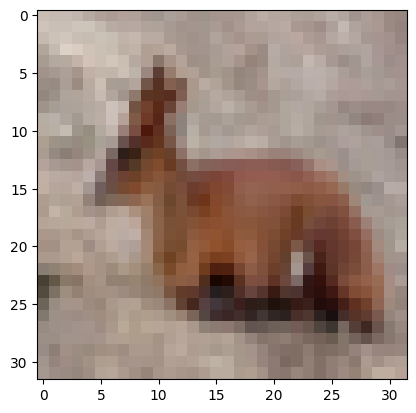

In [2]:
#Loading Cifar10 Data
def cifar10(X):
    with open(X, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

#Creating image array from Cifer10
def img(X):
    X = cifar10(X)
    X = X[b'data']/255
    X = X.reshape(X.shape[0],3,32,32)
    return X.transpose(0,2,3,1)

#Creating images with dark spot
def down(X):
    X = cifar10(X)
    X = X[b'data']/255
    X = X.reshape(X.shape[0],3,32,32)
    Y = []
    for i in range(0,X.shape[0]):
        A = cv2.resize(X[i][0], (16,16))
        A = np.kron(A, np.ones((2,2)))
        B = cv2.resize(X[i][1], (16,16))
        B = np.kron(B, np.ones((2,2)))
        C = cv2.resize(X[i][2], (16,16))
        C = np.kron(C, np.ones((2,2)))
        Y = Y + [[A,B,C]]
    Y = np.array(Y)
    return Y.transpose(0,2,3,1)

#Loading train data
def load_train(X):
    A = img(X + 'data_batch_1')
    for i in range(2,6):
        A = np.concatenate((A,img(X + 'data_batch_' + str(i))))
    B = down(X + 'data_batch_1')
    for i in range(2,6):
        B = np.concatenate((B,down(X + 'data_batch_' + str(i))))
    return A,B

#Loading test data
def load_test(X):
    A = img(X + 'test_batch')
    B = down(X + 'test_batch')
    return A,B


path = '/home/deb/cifar-10-batches-py/'
X_train, Y_train = load_train(path)
X_test, Y_test = load_test(path)
plt.imshow(X_train[1004])

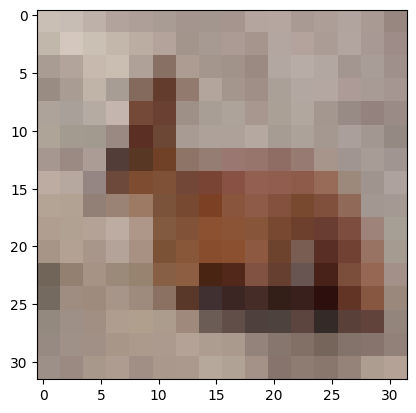

In [3]:
plt.imshow(Y_train[1004])

In [4]:
#Network
_input_ = Input(shape = (32, 32, 3))
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(_input_)
layer = BatchNormalization()(layer)
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
_output_ = Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')(layer)

upscaler = Model(_input_,_output_,name = 'Image_upscaler_CNN')
upscaler.compile(loss = 'binary_crossentropy', optimizer = 'adam')

cp = ModelCheckpoint('Image_upscaler_CNN.h5', save_best_only = True, save_weights_only = False, verbose = 1)
network = upscaler.fit(Y_train, X_train, batch_size = 128, epochs =30, callbacks = cp, validation_split = 0.25, verbose = 2)

2023-05-29 18:58:12.426681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 460800000 exceeds 10% of free system memory.
2023-05-29 18:58:17.257833: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 460800000 exceeds 10% of free system memory.


Epoch 1/30


2023-05-29 19:00:22.097126: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.
2023-05-29 19:00:23.468635: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.59985, saving model to Image_upscaler_CNN.h5
293/293 - 128s - loss: 0.5632 - val_loss: 0.5998 - 128s/epoch - 438ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.59985 to 0.55767, saving model to Image_upscaler_CNN.h5
293/293 - 202s - loss: 0.5548 - val_loss: 0.5577 - 202s/epoch - 691ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.55767 to 0.55561, saving model to Image_upscaler_CNN.h5
293/293 - 156s - loss: 0.5540 - val_loss: 0.5556 - 156s/epoch - 534ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.55561 to 0.55514, saving model to Image_upscaler_CNN.h5
293/293 - 157s - loss: 0.5535 - val_loss: 0.5551 - 157s/epoch - 535ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.55514
293/293 - 198s - loss: 0.5533 - val_loss: 0.5551 - 198s/epoch - 675ms/step
Epoch 6/30

Epoch 6: val_loss did not improve from 0.55514
293/293 - 153s - loss: 0.5530 - val_loss: 0.5553 - 153s/epoch - 521ms/step
Epoch 7/30

Epoch 7: val_loss improved 

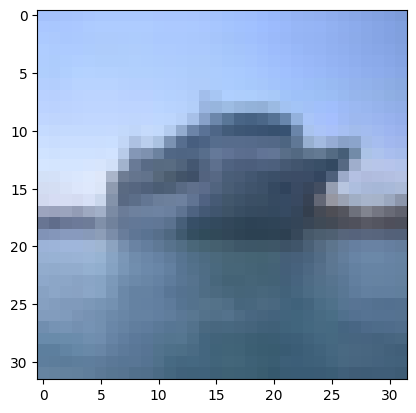

In [5]:
upscaler = load_model('Image_upscaler_CNN.h5')
plt.imshow(X_test[1004])

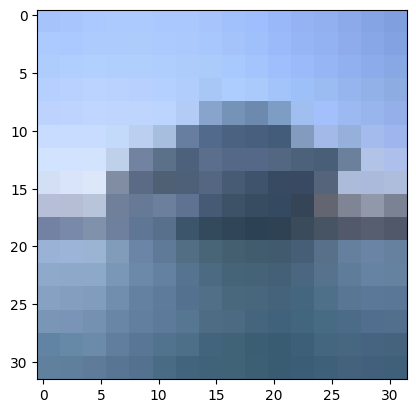

In [6]:
plt.imshow(Y_test[1004])

In [7]:
pred = upscaler.predict(Y_test)
pred.shape

2023-05-29 20:19:05.567767: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 6s 19ms/step


(10000, 32, 32, 3)

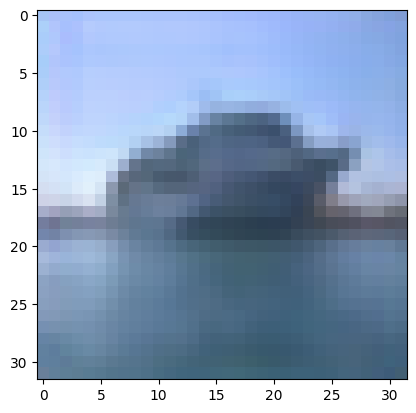

In [8]:
plt.imshow(pred[1004])